<a href="https://colab.research.google.com/github/ATOMconsortium/AMPL/blob/Tutorials/atomsci/ddm/examples/tutorials/03_Explore_Data_DTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring HTR3A protein target activity data from Drug Target Commons



# Scope of the tutorial
*   Input data from DTC dataset for HTR3A protein target
*   Retrieves SMILES string from PubChem (time consuming step; needs internet connection) 
*   AMPL will be used to accomplish the following steps: 
  *   Standardize SMILES string
  *   Clean the data (look for duplicates, average the assay data, cluster the compounds etc.)
  *   Carry out some Exploratory Data Analysis (Chemical space exploration; heat map, UMAP etc.) 
  *   Save the final dataset for modeling

# Time on COLAB-Pro ( ~ 6 minutes)

# Protein target (HTR3A) information

The Target specific data was downloaded from https://drugtargetcommons.fimm.fi/

Please refer to the Drug Target Commons publication (https://pubmed.ncbi.nlm.nih.gov/29276046/) for details about the database 

Here are some details about HTR3A gene (taken from RefSeq NCBI)

*   Proteins belongs to GPCR superfamily
*   HTR3a is a receptor for Serotonin, a biogenic hormone that functions as a neurotransmitter
*   HTR3A (also the name of the gene) encodes the subunit of the type 3 receptor for neurotransmitter 
*   Herteromeric combination of subunit A and B (HTR3B) is needed for full function. 
*   Different alternately spliced transcript variant forms for this gene are available.  

Diseases associated with HTR3A include Irritable Bowel Syndrome and Motion Sickness.

## Additional information about HTR3A gene:

**Gene location:** Chromosome 11
**Exon count:** 10

mRNA and protein information for its three transcripts:

*   NM_000869.6 → NP_000860.3 
*   NM_001161772.3 → NP_001155244.1
*   NM_213621.4 → NP_998786.3 

## Before you begin, make sure you close all other COLAB notebooks. 

# Change Runtime settings
If you have access to COLAB-Pro (commercial/not-free), please change your runtime settings to use GPU and high-memory,

```Runtime --> Change Runtime Type --> GPU with high-RAM```

If you are not a paid COLAB-Pro customer, you can still choose GPU, with standard-RAM.

In [1]:
!date # starting time

Fri May 21 03:59:05 UTC 2021


## Install AMPL

In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

!pip install deepchem-nightly

import deepchem
deepchem.__version__

! pip install umap
! pip install llvmlite==0.34.0  --ignore-installed
! pip install umap-learn
! pip install molvs
! pip install bravado

In [ ]:
import deepchem as dc

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

## Exploring HTR3A target activity data from ExcapeDB

In [4]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
# import numpy as np
# import pandas as pd
import os
import requests

In [5]:
#
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass,os

## Select a target to work with 
### (e.g. PDE2A, KCNH2, SCNA5)

In [6]:
target_name='HTR3A'

# Define data locations 

In [7]:
ofile=target_name+'_dtc.csv'

## Note the file `DTC_HTR3A.csv` was downloaded from the DTC website.

In [8]:
import io
url = 'https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/DTC_HTR3A.csv'
download = requests.get(url).content

In [9]:
# Reading the downloaded content and turning it into a pandas dataframe
orig_df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=',', header=0 )

In [10]:
orig_df.drop(columns=['Unnamed: 0'], inplace=True)
orig_df.columns

Index(['Compound ID', 'Uniprot ID', 'Compound Name', 'Standard inchi key',
       'Max Phase', 'Target Pref Name', 'Gene Names', 'Target Class',
       'Wild type or mutant', 'Mutation information', 'PubMed ID',
       'End Point Standard Type', 'End Point Standard Relation',
       'End Point Standard Value', 'End Point Standard Units',
       'Endpoint Mode of Action', 'Assay Format', 'Assay Type',
       'Assay Sub Type', 'Inhibitor Type', 'Detection Technology',
       'Compound concentration value', 'Compound concentration value units',
       'Substrate type', 'Substrate Type Standard Relation',
       'Substrate Type Standard Value', 'Substrate Type Standard Units',
       'Assay cell line', 'Assay Description', 'Activity Comments', 'Title',
       'Journal', 'Year', 'Volume', 'Issue', 'Authors', 'Annotation Comments',
       'Assay ID', 'DTC Tid', 'DTC Activity ID', 'DTC Molregno', 'Record ID',
       'DTC Document ID'],
      dtype='object')

### Start with a local file containing the target data

In [11]:
ofile=target_name+'_dtc.csv'

### Explore the dataframe and display first few lines

In [12]:
#show number of rows in data frame and number of columns
print(orig_df.shape)

# show column names
display(orig_df.columns)

(1310, 43)


Index(['Compound ID', 'Uniprot ID', 'Compound Name', 'Standard inchi key',
       'Max Phase', 'Target Pref Name', 'Gene Names', 'Target Class',
       'Wild type or mutant', 'Mutation information', 'PubMed ID',
       'End Point Standard Type', 'End Point Standard Relation',
       'End Point Standard Value', 'End Point Standard Units',
       'Endpoint Mode of Action', 'Assay Format', 'Assay Type',
       'Assay Sub Type', 'Inhibitor Type', 'Detection Technology',
       'Compound concentration value', 'Compound concentration value units',
       'Substrate type', 'Substrate Type Standard Relation',
       'Substrate Type Standard Value', 'Substrate Type Standard Units',
       'Assay cell line', 'Assay Description', 'Activity Comments', 'Title',
       'Journal', 'Year', 'Volume', 'Issue', 'Authors', 'Annotation Comments',
       'Assay ID', 'DTC Tid', 'DTC Activity ID', 'DTC Molregno', 'Record ID',
       'DTC Document ID'],
      dtype='object')

In [13]:
orig_df.head(5)

,Compound ID,Uniprot ID,Compound Name,Standard inchi key,Max Phase,Target Pref Name,Gene Names,Target Class,Wild type or mutant,Mutation information,PubMed ID,End Point Standard Type,End Point Standard Relation,End Point Standard Value,End Point Standard Units,Endpoint Mode of Action,Assay Format,Assay Type,Assay Sub Type,Inhibitor Type,Detection Technology,Compound concentration value,Compound concentration value units,Substrate type,Substrate Type Standard Relation,Substrate Type Standard Value,Substrate Type Standard Units,Assay cell line,Assay Description,Activity Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation Comments,Assay ID,DTC Tid,DTC Activity ID,DTC Molregno,Record ID,DTC Document ID
0,CHEMBL100086,P46098,NaN,OSVMSQACZRYAPT-UHFFFAOYSA-N,0,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,12482441.0,IC50,>,100000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibitory concentration required against 5-HT...,NaN,Development of a presynaptic 5-HT1A antagonist.,Bioorg. Med. Chem. Lett.,2003.0,13.0,2.0,"Mattson RJ, Catt JD, Sloan CP, Gao Q, Carter R...",NaN,3062.0,DTCT0023221,1489397,DTCC00263953,917398,5847
1,CHEMBL104700,P46098,NaN,SCDKHPSUXHBJDJ-UHFFFAOYSA-N,0,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,22607684.0,KI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of 5-HT3 receptor,Not Determined,7-Azabicyclo[2.2.1]heptane as a scaffold for t...,Bioorg. Med. Chem. Lett.,2012.0,22.0,12.0,"Banister SD, Rendina LM, Kassiou M",NaN,820298.0,DTCT0023221,10478126,DTCC00272114,931177,48255
2,CHEMBL1079079,P46098,NaN,WGIPGQAPFNVWIX-XXFZXMJFSA-N,0,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,19767206.0,INHIBITION,<,50.0,%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Displacement of [3H]LY278584 from 5HT3 (recept...,NaN,Synthesis and in vitro autoradiographic evalua...,Bioorg. Med. Chem. Lett.,2009.0,19.0,21.0,"Donohue SR, Varnäs K, Jia Z, Gulyás B, Pike VW...",NaN,619795.0,DTCT0023221,3267809,DTCC00632772,857661,37697
3,CHEMBL108,P46098,CARBAMAZEPINE,FFGPTBGBLSHEPO-UHFFFAOYSA-N,4,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,19144451.0,INHIBITION,<=,50.0,%,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HEK293,Antagonist activity at human 5HT3A receptor ex...,NaN,Molecular properties of psychopharmacological ...,Eur. J. Med. Chem.,2009.0,44.0,6.0,"Kornhuber J, Terfloth L, Bleich S, Wiltfang J,...",NaN,572131.0,DTCT0023221,2849452,DTCC00144764,229550,34292
4,CHEMBL1082723,P46098,NITD609,CKLPLPZSUQEDRT-WPCRTTGESA-N,0,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,20813948.0,IC50,>,10000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Binding affinity to human recombinant serotoni...,NaN,"Spiroindolones, a potent compound class for th...",Science,2010.0,329.0,5996.0,"Rottmann M, McNamara C, Yeung BK, Lee MC, Zou ...",NaN,658586.0,DTCT0023221,3467863,DTCC00031143,1686650,40818


## Let us use AMPL to prefilter the data

In [14]:
print('Before replace: ', orig_df.columns)
# remove special character 
orig_df.columns = orig_df.columns.str.replace(' ', '_')  
print('After replace: ', orig_df.columns)

Before replace:  Index(['Compound ID', 'Uniprot ID', 'Compound Name', 'Standard inchi key',
       'Max Phase', 'Target Pref Name', 'Gene Names', 'Target Class',
       'Wild type or mutant', 'Mutation information', 'PubMed ID',
       'End Point Standard Type', 'End Point Standard Relation',
       'End Point Standard Value', 'End Point Standard Units',
       'Endpoint Mode of Action', 'Assay Format', 'Assay Type',
       'Assay Sub Type', 'Inhibitor Type', 'Detection Technology',
       'Compound concentration value', 'Compound concentration value units',
       'Substrate type', 'Substrate Type Standard Relation',
       'Substrate Type Standard Value', 'Substrate Type Standard Units',
       'Assay cell line', 'Assay Description', 'Activity Comments', 'Title',
       'Journal', 'Year', 'Volume', 'Issue', 'Authors', 'Annotation Comments',
       'Assay ID', 'DTC Tid', 'DTC Activity ID', 'DTC Molregno', 'Record ID',
       'DTC Document ID'],
      dtype='object')
After replace:  In

In [15]:
# replace uppercase to lowercase
orig_df.columns= orig_df.columns.str.lower()
print('After replaceing colnames with lcase: ', orig_df.columns)

After replaceing colnames with lcase:  Index(['compound_id', 'uniprot_id', 'compound_name', 'standard_inchi_key',
       'max_phase', 'target_pref_name', 'gene_names', 'target_class',
       'wild_type_or_mutant', 'mutation_information', 'pubmed_id',
       'end_point_standard_type', 'end_point_standard_relation',
       'end_point_standard_value', 'end_point_standard_units',
       'endpoint_mode_of_action', 'assay_format', 'assay_type',
       'assay_sub_type', 'inhibitor_type', 'detection_technology',
       'compound_concentration_value', 'compound_concentration_value_units',
       'substrate_type', 'substrate_type_standard_relation',
       'substrate_type_standard_value', 'substrate_type_standard_units',
       'assay_cell_line', 'assay_description', 'activity_comments', 'title',
       'journal', 'year', 'volume', 'issue', 'authors', 'annotation_comments',
       'assay_id', 'dtc_tid', 'dtc_activity_id', 'dtc_molregno', 'record_id',
       'dtc_document_id'],
      dtype='objec

In [16]:
# checking after rename
orig_df.columns

Index(['compound_id', 'uniprot_id', 'compound_name', 'standard_inchi_key',
       'max_phase', 'target_pref_name', 'gene_names', 'target_class',
       'wild_type_or_mutant', 'mutation_information', 'pubmed_id',
       'end_point_standard_type', 'end_point_standard_relation',
       'end_point_standard_value', 'end_point_standard_units',
       'endpoint_mode_of_action', 'assay_format', 'assay_type',
       'assay_sub_type', 'inhibitor_type', 'detection_technology',
       'compound_concentration_value', 'compound_concentration_value_units',
       'substrate_type', 'substrate_type_standard_relation',
       'substrate_type_standard_value', 'substrate_type_standard_units',
       'assay_cell_line', 'assay_description', 'activity_comments', 'title',
       'journal', 'year', 'volume', 'issue', 'authors', 'annotation_comments',
       'assay_id', 'dtc_tid', 'dtc_activity_id', 'dtc_molregno', 'record_id',
       'dtc_document_id'],
      dtype='object')

In [17]:
orig_df.shape

(1310, 43)

## The following renames the names and make it suitable for the next function call

In [18]:
orig_df = orig_df.rename(columns={'end_point_standard_type': 'standard_type', 
 'end_point_standard_relation': 'standard_relation',
 'end_point_standard_value': 'standard_value', 
 'end_point_standard_units': 'standard_units',
 'endpoint_mode_of_action': 'mode_of_action',
 'wild_type_or_mutant': 'wildtype_or_mutant'})

## dcf.filter_dtc_data performs the following operation

```
dset_df = orig_df[orig_df.gene_names.isin(geneNames) &
                      ~(orig_df.standard_inchi_key.isna()) &
                      (orig_df.standard_type == 'IC50') &
                      (orig_df.standard_units == 'NM') &
                      ~orig_df.standard_value.isna() &
                      ~orig_df.compound_id.isna() &
                      (orig_df.wildtype_or_mutant != 'mutated') ]
 ```

In [19]:
geneNames = [target_name]
nm_df = dcf.filter_dtc_data(orig_df, geneNames)

In [20]:
orig_df.shape

(1310, 43)

In [21]:
nm_df.shape

(226, 43)

## Explore few columns to get an idea of the dataset

In [ ]:
# Below, we are displaying the unique elements of our assaytype column in our dataframe
# unique() is a function that is a part of the numpy library in Python, and it is used to find the unique elements of an array
display(orig_df['assay_type'].unique())

# We then use the same function on a few more columns: assay_cell_line, assay_description, pubmed_id
display(orig_df['assay_cell_line'].unique())
display(orig_df['assay_description'].unique())
display(orig_df['pubmed_id'].unique())

In [23]:
orig_df.head(3)

,compound_id,uniprot_id,compound_name,standard_inchi_key,max_phase,target_pref_name,gene_names,target_class,wildtype_or_mutant,mutation_information,pubmed_id,standard_type,standard_relation,standard_value,standard_units,mode_of_action,assay_format,assay_type,assay_sub_type,inhibitor_type,detection_technology,compound_concentration_value,compound_concentration_value_units,substrate_type,substrate_type_standard_relation,substrate_type_standard_value,substrate_type_standard_units,assay_cell_line,assay_description,activity_comments,title,journal,year,volume,issue,authors,annotation_comments,assay_id,dtc_tid,dtc_activity_id,dtc_molregno,record_id,dtc_document_id
0,CHEMBL100086,P46098,NaN,OSVMSQACZRYAPT-UHFFFAOYSA-N,0,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,12482441.0,IC50,>,100000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibitory concentration required against 5-HT...,NaN,Development of a presynaptic 5-HT1A antagonist.,Bioorg. Med. Chem. Lett.,2003.0,13.0,2.0,"Mattson RJ, Catt JD, Sloan CP, Gao Q, Carter R...",NaN,3062.0,DTCT0023221,1489397,DTCC00263953,917398,5847
1,CHEMBL104700,P46098,NaN,SCDKHPSUXHBJDJ-UHFFFAOYSA-N,0,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,22607684.0,KI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of 5-HT3 receptor,Not Determined,7-Azabicyclo[2.2.1]heptane as a scaffold for t...,Bioorg. Med. Chem. Lett.,2012.0,22.0,12.0,"Banister SD, Rendina LM, Kassiou M",NaN,820298.0,DTCT0023221,10478126,DTCC00272114,931177,48255
2,CHEMBL1079079,P46098,NaN,WGIPGQAPFNVWIX-XXFZXMJFSA-N,0,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,19767206.0,INHIBITION,<,50.0,%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Displacement of [3H]LY278584 from 5HT3 (recept...,NaN,Synthesis and in vitro autoradiographic evalua...,Bioorg. Med. Chem. Lett.,2009.0,19.0,21.0,"Donohue SR, Varnäs K, Jia Z, Gulyás B, Pike VW...",NaN,619795.0,DTCT0023221,3267809,DTCC00632772,857661,37697


## Convert InChi key to SMILES

In [24]:
ofile = target_name+'_dtc_smiles_raw.csv'

In [25]:
print(ofile)

HTR3A_dtc_smiles_raw.csv


## Note the file HTR3A_dtc_smiles_raw.csv will be created

In [26]:
# import few libraries from AMPL
import atomsci.ddm.utils.pubchem_utils as pu
from os import path

myList = orig_df['standard_inchi_key'].unique().tolist()

# Retrieve SMILES strings for compounds through PUBCHEM web interface.

# Let us make sure the ofile exists, if it exists then print 'File exists' and 
# if it doesnt exist, let us print "SMILES data doesnt not exist, downloading from
# PubCHEM"

if not path.exists(ofile) :
    print("SMILES data not found, download from PubChem ",ofile)
    save_smiles_df, fail_lst, discard_lst = pu.download_smiles(myList)
    save_smiles_df.to_csv(ofile)
else :
    print(ofile, 'Exists!')


SMILES data not found, download from PubChem  HTR3A_dtc_smiles_raw.csv


## Note the `fail_lst` and `discard_lst` will contain the failed and discarded list 

Check whether the file, HTR3A_dtc_smiles_raw.csv, exists. use the RHS menu option or use `ls HTR3A_dtc_smiles_raw.csv`

In [27]:
print("fail_lst: ", len(fail_lst))
print("discard_lst: ", len(discard_lst))
print(len(myList))
print(save_smiles_df.shape)

fail_lst:  60
discard_lst:  19
992
(932, 3)


In [28]:
save_smiles_df.head(5)

,CID,standard_inchi_key,smiles
0,9845261,OSVMSQACZRYAPT-UHFFFAOYSA-N,"""COC1=CC=CC(=C1)CN2CCN(CC2)C3CCC(CC3)(C4=CC5=C..."
1,10130293,SCDKHPSUXHBJDJ-UHFFFAOYSA-N,"""C1CC2CCC1N2CC3=CN=CC=C3"""
2,44471685,WGIPGQAPFNVWIX-XXFZXMJFSA-N,"""COC1=CC=C(C=C1)C2=C(C(=NN2C3=CC=CC=C3I)C(=O)N..."
3,2554,FFGPTBGBLSHEPO-UHFFFAOYSA-N,"""C1=CC=C2C(=C1)C=CC3=CC=CC=C3N2C(=O)N"""
4,44469321,CKLPLPZSUQEDRT-WPCRTTGESA-N,"""CC1CC2=C(C3(N1)C4=C(C=CC(=C4)Cl)NC3=O)NC5=CC(..."


## In this step, we reassemble the dataframe by attaching the IC50 values to create a new dataframe  

In [ ]:
# HTR3A_dtc_smiles.csv is the ofile 
ofile = target_name+'_dtc_smiles.csv'
if not path.exists(ofile) :
    import atomsci.ddm.utils.data_curation_functions as dcf
    import importlib as impl

    print(len(fail_lst))
    print(save_smiles_df.shape)

# Above, we will pring the fail_list created in the earlier code block 
# We will also print the dimensions of our save_smiles_df pandas 
# dataframe using the .shape function

# Notice the ifile is now HTR3A_dtc_smiles_raw.csv
    ifile=target_name+'_dtc_smiles_raw.csv'

# Here we are reading in our file (ifile) using the pandas library, and assigning its contents to the save_smiles_df from earlier
    save_smiles_df=pd.read_csv(ifile)

    ## Retrieve specific data
    ## Will include censored data in smiles 
    ## Combine gene data with SMILES strings and call this our starting "raw" dataset.
# Here we are creating a variable called targ_lst, which contains our target and is formatted as a list
    targ_lst=[target_name]
    ####WARNING: I had to convert this explicitly to a floating point value!!!
# Below, using the nm_df['standard_value']=nm_df['standard_value'].astype(float) is used to convert 
# the standard_value column into a float using astype()
# A floating point value, also called a float, represents a real number and is written with a decimal point dividing the integer and fractional point
    nm_df['standard_value']=nm_df['standard_value'].astype(float)
    smiles_lst, shared_inchi_keys = dcf.get_smiles_dtc_data(nm_df, targ_lst, save_smiles_df)
    smiles_df=pd.concat(smiles_lst)
    # ofile=target_name+'_dtc_smiles.csv'
    smiles_df.to_csv(ofile,index=False)
else :
    print("Downloaded file previously saved",ofile)

## Change the ofile to ifile for reading

In [30]:
ifile=target_name+'_dtc_smiles.csv'
print(ifile)

HTR3A_dtc_smiles.csv


In [31]:
print(smiles_df.shape)
save_smiles_df = smiles_df
save_smiles_df.head(5)

(220, 48)


,compound_id,uniprot_id,compound_name,standard_inchi_key,max_phase,target_pref_name,gene_names,target_class,wildtype_or_mutant,mutation_information,pubmed_id,standard_type,standard_relation,standard_value,standard_units,mode_of_action,assay_format,assay_type,assay_sub_type,inhibitor_type,detection_technology,compound_concentration_value,compound_concentration_value_units,substrate_type,substrate_type_standard_relation,substrate_type_standard_value,substrate_type_standard_units,assay_cell_line,assay_description,activity_comments,title,journal,year,volume,issue,authors,annotation_comments,assay_id,dtc_tid,dtc_activity_id,dtc_molregno,record_id,dtc_document_id,PIC50,Unnamed: 0,CID,smiles,rdkit_smiles
0,CHEMBL100086,P46098,NaN,OSVMSQACZRYAPT-UHFFFAOYSA-N,0,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,12482441.0,IC50,>,100000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibitory concentration required against 5-HT...,NaN,Development of a presynaptic 5-HT1A antagonist.,Bioorg. Med. Chem. Lett.,2003.0,13.0,2.0,"Mattson RJ, Catt JD, Sloan CP, Gao Q, Carter R...",NaN,3062.0,DTCT0023221,1489397,DTCC00263953,917398,5847,4.000000,0,9845261,COC1=CC=CC(=C1)CN2CCN(CC2)C3CCC(CC3)(C4=CC5=C(...,COc1cccc(CN2CCN(C3CCC(O)(c4ccc5c(c4)OCO5)CC3)C...
1,CHEMBL1082723,P46098,NITD609,CKLPLPZSUQEDRT-WPCRTTGESA-N,0,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,20813948.0,IC50,>,10000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Binding affinity to human recombinant serotoni...,NaN,"Spiroindolones, a potent compound class for th...",Science,2010.0,329.0,5996.0,"Rottmann M, McNamara C, Yeung BK, Lee MC, Zou ...",NaN,658586.0,DTCT0023221,3467863,DTCC00031143,1686650,40818,5.000000,4,44469321,CC1CC2=C(C3(N1)C4=C(C=CC(=C4)Cl)NC3=O)NC5=CC(=...,CC1Cc2c([nH]c3cc(Cl)c(F)cc23)C2(N1)C(=O)Nc1ccc...
2,CHEMBL1083485,P46098,NaN,YOCUJVXRRWEPDN-UHFFFAOYSA-N,0,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,20465311.0,IC50,>,30000.0,NM,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HEK293,Agonist activity at human 5HT3A receptor expre...,NaN,Novel alpha-7 nicotinic acetylcholine receptor...,J. Med. Chem.,2010.0,53.0,11.0,"Ghiron C, Haydar SN, Aschmies S, Bothmann H, C...",NaN,634700.0,DTCT0023221,3345977,DTCC00645978,1654372,39082,4.522879,5,44611748,C1CCN(CC1)CCCCNC(=O)NC2=CN=C(C=C2)C3=CC=CC=C3F,O=C(NCCCCN1CCCCC1)Nc1ccc(-c2ccccc2F)nc1
3,CHEMBL1083787,P46098,NaN,LMGUUVWYFJIKCD-UHFFFAOYSA-N,0,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,20465311.0,IC50,>,30000.0,NM,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HEK293,Agonist activity at human 5HT3A receptor expre...,NaN,Novel alpha-7 nicotinic acetylcholine receptor...,J. Med. Chem.,2010.0,53.0,11.0,"Ghiron C, Haydar SN, Aschmies S, Bothmann H, C...",NaN,634700.0,DTCT0023221,3345978,DTCC00645979,1395966,39082,4.522879,6,44240743,C1CCN(CC1)CCCCNC(=O)NC2=CN=C(C=C2)C3=CC=C(C=C3)F,O=C(NCCCCN1CCCCC1)Nc1ccc(-c2ccc(F)cc2)nc1
4,CHEMBL1083788,P46098,NaN,DFBQTBNRGSIKHN-UHFFFAOYSA-N,0,SEROTONIN 3A (5-HT3A) RECEPTOR,HTR3A,Ion channel,NaN,NaN,20465311.0,IC50,>,30000.0,NM,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HEK293,Agonist activity at human 5HT3A receptor expre...,NaN,Novel alpha-7 nicotinic acetylcholine receptor...,J. Med. Chem.,2010.0,53.0,11.0,"Ghiron C, Haydar SN, Aschmies S, Bothmann H, C...",NaN,634700.0,DTCT0023221,3345979,DTCC00645980,652015,39082,4.522879,7,44611875,C1CCN(CC1)CCCCNC(=O)NC2=CN=C(C=C2)C3=CN=C(C=C3)F,O=C(NCCCCN1CCCCC1)Nc1ccc(-c2ccc(F)nc2)nc1


## Use AMPL for transforming IC50 values

Post-processing dataset

Total Number of results = 220
dataset mean = 5.689316219635005 NM
dataset stdev = 1.321131252987626 NM
dataset max = 10.045757490560675 NM
dataset min = 3.6000000054478725 NM



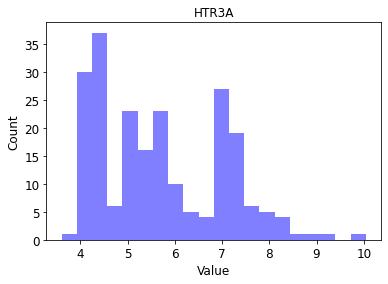

In [32]:
# From our dataframe, we are working with the PIC50 column 
# !=np.inf uses the Numpy library and the != portion checks to see if the value 
# of two operands, the object of an operation, are equal. If they are not equal the 
# condition is true
# The np.inf portion indicates the Numpy module which can be used to represent 
# positive infinite value
data=save_smiles_df[save_smiles_df['PIC50'] != np.inf]

# Here we are defining our column, which will be PIC50
column = 'PIC50'

# Here we are using the num_bins parameter to determine the number of bins our data will be divided into, creating 20 different peaks
# These peaks will be visualized on our graph
num_bins = 20

# Here we are setting our title for the graph as our target name 
title = target_name

# Here we are specifying the units that are used, which in our case we are using nanometers 
units = 'NM'

# Using the filepath function, we are defining our file
filepath = ""

# This is the same variable we created earlier called data 
data=save_smiles_df[save_smiles_df['PIC50'] != np.inf]

# Using the summarize_data submodule, we are going to compile a set of data summarization tools to calculate several descriptive features
# These features include: column, num_bins, title, units, filepath, and data
curate_data.summarize_data(column, num_bins, title, units, filepath, data)

## Let us cluster the compounds to explore the chemical space


Project compounds into two dimensions with UMAP and Tanimoto similiarty

1.   Cluster compounds by Tanimoto similarity
2.   Repeat steps 1 and 2 with Maximum Common Substructure distance when dataset size is below # threshold (default < 300)

See documentation here:
 https://ampl.readthedocs.io/en/latest/pipeline.html?highlight=diversity_plots#pipeline.diversity_plots.diversity_plots

 </li>

# Save output from clustering heatmap to image and upload to presentation

In [33]:
ifile = target_name+'_dtc_smiles.csv'

# Plot self similarity (Tanimoto) within dataset and show distribution of distances between compounds in dataset for nearest neighbor.

## Save  distribution plot as an image.

We will be calling dp.diversity_function from AMPL in the following code chunk. For AMPL function explanations, 
please consult AMPL documentation here, https://ampl.readthedocs.io/en/latest/pipeline.html?highlight=diversity_plots#pipeline.diversity_plots.diversity_plots 

## Here is a brief explanation of `dp` function: 

### The AMPL function will calculate diversity profile for the data. 

### Input Args:


*   **dset_key:** : Name of the input data variable 
*   **datastore** : 
*   **id_col**    : Ambit_InchiKey, it is a chemical identifier for the compound or drug molecules. Please check here for a detailed explanation of InChiKey, https://en.wikipedia.org/wiki/International_Chemical_Identifier#:~:text=%2B%2Fm0%2Fs1-,InChIKey,hashed%20counterpart%20of%20standard%20InChI. In this case, Excape is using InChiKey generated from Ambit
*   **response_col**: Outcome column, in out case it is pXC50

## `dp.diversity_plots` function

*    Computes Fingerprints 
*    If the number of compounds are > 300, it will compute Fingerprints and use it to compute Tanimoto distance matrix. plot the distances using UMAP projection and cluster (complete cluster method will be used) the distances to create a heatmap
*   If the number of compounds are < 100, MCS (Maximum Common Substructure) will be used for clustering in addition the above step. 


## Helpful links

* Tanimoto 
    * https://en.wikipedia.org/wiki/Jaccard_index
    * https://en.wikipedia.org/wiki/Chemical_similarity
* UMAP
    * https://pair-code.github.io/understanding-umap/
* MCS
    * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2718661/ 

Canonicalizing 184 molecules...
Done
Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


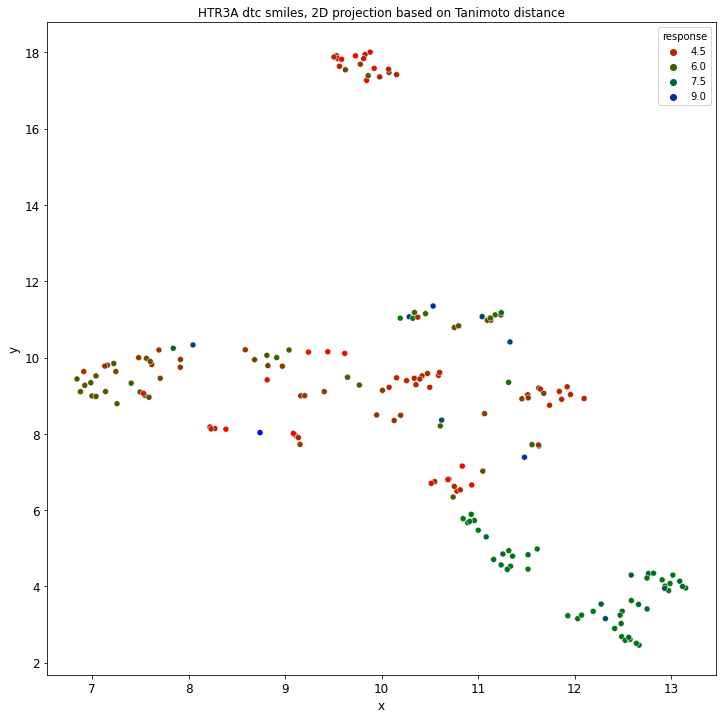

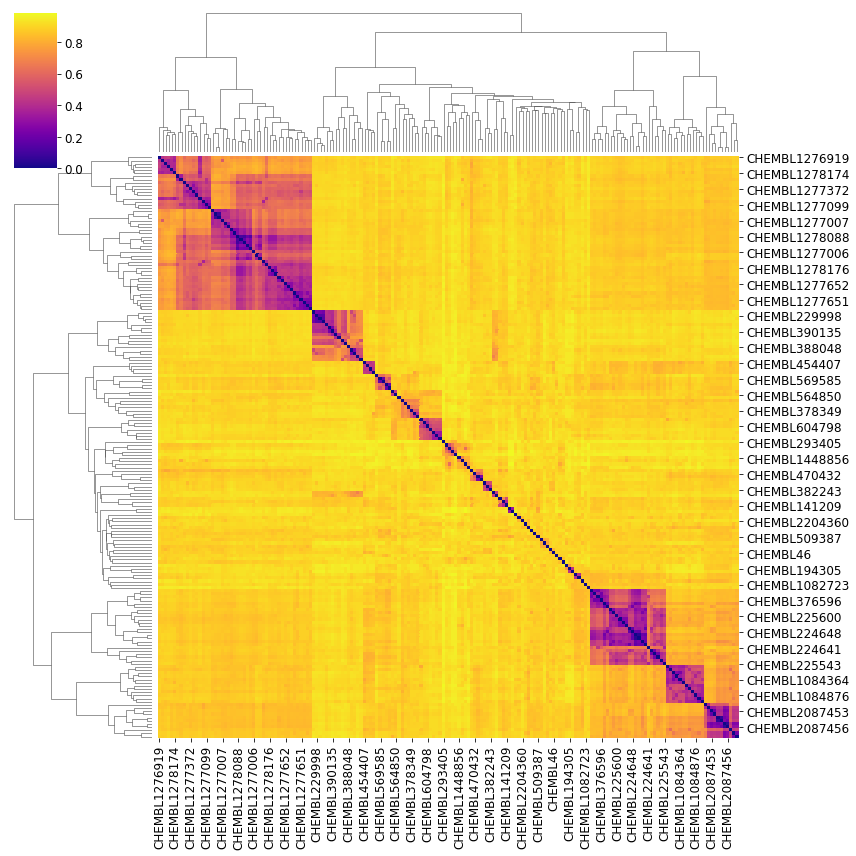

In [34]:
dp.diversity_plots(dset_key = ifile,
                   datastore = False,
                   response_col = 'PIC50',
                   max_for_mcs = 100)

In [35]:
data.shape

(220, 48)

## Self similarity (Tanimoto) 

Calculate self-similarity (using Tanimoto) for the dataset and plot the distanes. 

In [36]:
feat_type = 'ECFP'
dist_metric = 'tanimoto'
smiles_lst1 = data['rdkit_smiles'].tolist()
calc_type = 'nearest'
dist_sample = cd.calc_dist_smiles(feat_type, dist_metric, smiles_lst1, None, calc_type)

In [37]:
print(len(dist_sample))
print(len(smiles_lst1))

220
220


## What does **calc_dist_smiles** function return? 


*   input is a list of SMILES strings
*   data featurization: ECFP (Fingerprint)
*   What distance metric to use? Tanimoto
*   How to process distance matrix, nearest ?
*   returns a distance matrix as a vector of distances

Here is the function summary:

*   rdkit is used to transform SMILES to mols
*   mols to FP (Morgan, 1024 FP)
*   calls calc_summary with the following options: 
         * fprints1 is the FP 
         * fprints2 is none 
         * dist_metrics will return a distance matrix
    calc_summary(dist_metrics.tanimoto(fprints1, fprints2), calc_type=nearest, num_nearest=1, within_dset=True)

* Finally, returns the distances of each atom to its closest neighbor 



## Explanation for the following code chunk

* **scipy.stats.kde** will use kernel density function to estimate the probability density function (PDE)
---



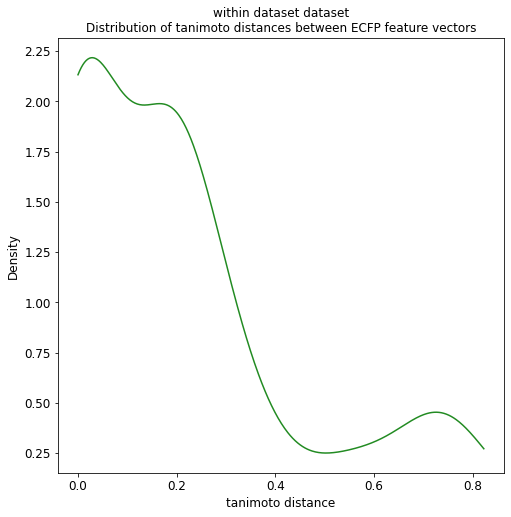

In [38]:
from scipy.stats.kde import gaussian_kde

# import math library
import numpy as np

# for creating plots
import matplotlib.pyplot as plt

# current directory
odir='./'

# name for the task
task_name='within dataset'

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
dist_pdf = gaussian_kde(dist_sample)
x_plt = np.linspace(min(dist_sample), max(dist_sample), 500)
y_plt = dist_pdf(x_plt)    
fig, ax = plt.subplots(figsize=(8.0,8.0))
ax.plot(x_plt, y_plt, color='forestgreen')
ax.set_xlabel('%s distance' % dist_metric)
ax.set_ylabel('Density')
ax.set_title("%s dataset\nDistribution of %s distances between %s feature vectors" % (
              task_name, dist_metric, feat_type))
fig.savefig(odir+'distance_to_background_mol.png')

In [39]:
!date # ending time

Fri May 21 04:07:14 UTC 2021
